In [18]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm
from scipy import stats
import sys
sys.path.append("..")
from d2l import torch as d2l
 
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.9.0


In [19]:
train_data = pd.read_csv(r'data/train.csv')
test_data = pd.read_csv(r'data/test.csv')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

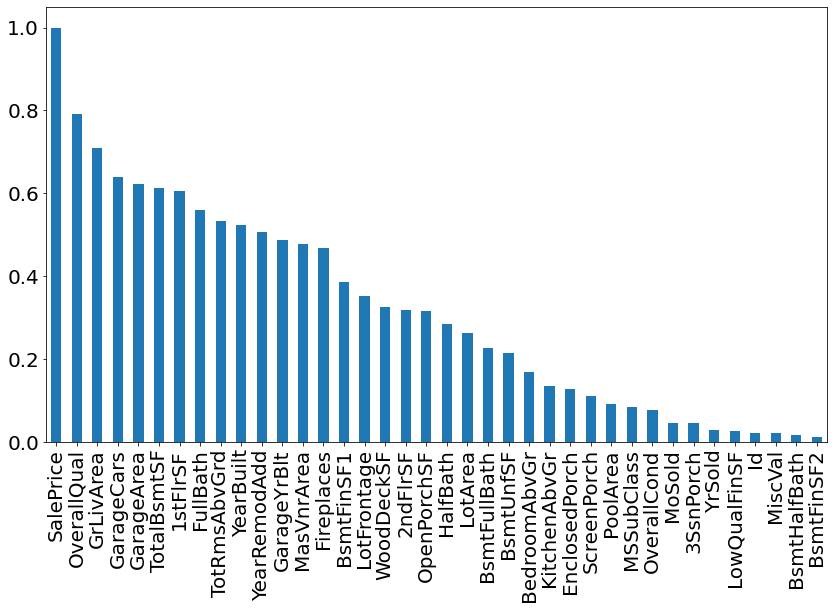

In [20]:

fig = plt.figure(figsize=(14,8))
abs(train_data.corr()['SalePrice']).sort_values(ascending=False).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

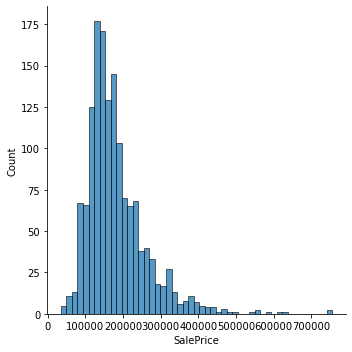

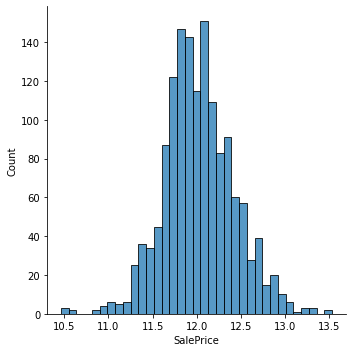

In [21]:
sns.displot(train_data['SalePrice'])
sns.displot(np.log(train_data['SalePrice']))#取对数后的

<Figure size 432x288 with 0 Axes>

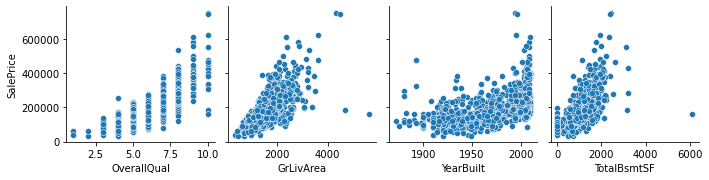

In [22]:

figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [23]:

train_data = train_data.drop(train_data[(train_data['OverallQual']<5) &
                                        (train_data['SalePrice']>200000)].index)
 
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) &
                                        (train_data['SalePrice']<300000)].index)
 
train_data = train_data.drop(train_data[(train_data['YearBuilt']<1900) &
                                        (train_data['SalePrice']>400000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) &
                                        (train_data['SalePrice']<200000)].index)


<Figure size 432x288 with 0 Axes>

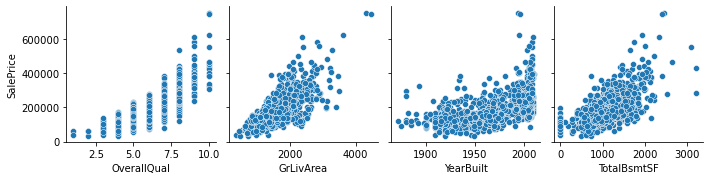

In [24]:
#检查是否还存在异常值
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [25]:

all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [26]:
#观察数据的缺失情况
nan_index=((all_features.isnull().sum()/len(all_features))).sort_values(ascending=False)#34个缺失值
print(nan_index)

PoolQC           0.996913
MiscFeature      0.963979
Alley            0.932075
Fence            0.804460
FireplaceQu      0.487136
                   ...   
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
SaleCondition    0.000000
Length: 79, dtype: float64


In [27]:
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
#对数据进行标准化
all_features[numeric_features]=all_features[numeric_features].apply(
        lambda x:(x-x.mean())/(x.std()))
#标准化后，每个数值特征的均值变为0，可以直接用0来替换缺失值
all_features[numeric_features]=all_features[numeric_features].fillna(0)
#离散数值转成指示特征
all_features=pd.get_dummies(all_features,dummy_na=True)#通过转换将特征数从79增加到了330


In [28]:
#先把合并的数据集重新分割为训练集和测试集
n_train=train_data.shape[0]
#通过values属性得到Numpy格式的数据，并转成Tensor方便后面的训练
#训练样本特征
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
#测试样本特征
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
#训练样本标签
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [29]:
#定义均方误差损失函数
loss=torch.nn.MSELoss()

In [50]:
#定义线性回归模型
def get_net(feature_num):
    net=nn.Sequential(
            nn.Linear(feature_num,256),
            nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(256,128),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(256,1),
            )
    #模型参数初始化
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [51]:
#对数均方误差的实现
def log_rmse(net,features,labels):
    with torch.no_grad():
        #将小于1的值设成1，使的取对数时数值更稳定
        clipped_preds=torch.max(net(features),torch.tensor(1.0))
        rmse=torch.sqrt(loss(clipped_preds.log(),labels.log()))
    return rmse.item()

In [52]:
def train(net,train_features,train_labels,test_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    #把dataset放入DataLoader
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    #这里使用了Adam优化算法
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net=net.float()#将神经网络中的数据类型设置维浮点型
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [53]:
#K折交叉验证
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        #划分出验证数据集
        if j==1:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        #划分出训练数据，剩下的进行合并
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            #dim=0按列合并
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid
def k_fold(k,X_train,y_train,num_epochs,
           learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,
                                weight_decay,batch_size)
        #误差累计
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
            #输出相应的结果：训练误差、验证误差
        print('fold%d,train rmse %f,valid rmse %f'%
              (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

fold0,train rmse 0.082102,valid rmse 0.129866
fold1,train rmse 0.077834,valid rmse 0.126545


KeyboardInterrupt: 

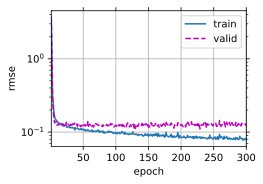

In [54]:
#模型选择
k,num_epochs,lr,weight_decay,batch_size=8,300,0.01,300,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg trian rmse %f,avg valid rmse %f'%
      (k,train_l,valid_l))

In [ ]:
#模型预测
def train_and_pred(train_features,test_features,train_labeld,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net=get_net(train_features.shape[1])
    #第二个变量（测试误差）缺省，用_代替
    train_ls,_=train(net,train_features,train_labels,None,None,
                     num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print('train rmse %f'%train_ls[-1])
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)   

train rmse 0.097954


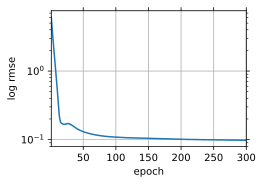

In [ ]:
train_and_pred(train_features,test_features,train_labels,
               test_data,num_epochs,lr,weight_decay,batch_size)  